For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [ ]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,25):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [ ]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [3]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [4]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [5]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [6]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# Added by David:
# 4a. Create dictionary of road-pixel matrices

In [ ]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [7]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

Of roadtype G (Gemeente) there are 4963 tiles.
Of roadtype W (Waterschap) there are 915 tiles.
Of roadtype P (Provincie) there are 48 tiles.
Of roadtype T (Andere wegbeheerder) there are 1 tiles.


# 5. Prepare dataset for CNN

In [8]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def onehot_encode_labels(labels):
    list_possible_labels = list(np.unique(labels))
    encoded_labels = map(lambda x: list_possible_labels.index(x), labels)
    return encoded_labels

def randomize(dataset, labels1, labels2, labels3):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation]
    randomized_labels2 = labels2[permutation]
    randomized_labels3 = labels3[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2, randomized_labels3

def one_hot_encode(np_array, num_unique_labels):
    return (np.arange(num_unique_labels) == np_array[:,None]).astype(np.float32)

def reformat_data(dataset, labels1, labels2, labels3):
    dataset, labels1, labels2, labels3 = randomize(dataset, labels1, labels2, labels3)
    num_unique_labels1 = len(np.unique(labels1))
    num_unique_labels2 = len(np.unique(labels2))
    labels1 = one_hot_encode(labels1, num_unique_labels1)
    labels2 = one_hot_encode(labels2, num_unique_labels2)
    print(dataset.shape)
    print(labels1.shape)
    return dataset, labels1, labels2, labels3

#  5a. Resize images and labels to 64*64--create label for road / no road

In [9]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
split_factor = 4

new_image_height = int(image_height/split_factor)
new_image_width = int(image_width/split_factor)

image_files = os.listdir(INPUT_FOLDER_TILES)

# Initialize new datasets for cropped images
labels_filename = []
dataset = np.ndarray(shape=(total_no_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
labels_roadpresence = np.ndarray(total_no_images, dtype=np.float32)
labels_roadtype = []
roads_present  = 0;
roads_absent  = 0;
# Loop through each image and add to dataset
for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    labels_filename.append(image)
    if image in list(d_tile_contents.keys()):
        tile_contents = d_tile_contents[image]
        roadtypes = sorted(list(set([elem[0] for elem in tile_contents])))
        roadtype = "_".join(roadtypes)
        labels_roadpresence[counter] = 1
        # labels_roadpixel[counter] = d_road_pixels[image]
    else:
        roadtype = ''
        labels_roadpresence[counter] = 0
        # labels_roadpixel[counter,:,:] = np.zeros((image_width, image_height))
    labels_roadtype.append(roadtype) 
    image_data = np.asarray(Image.open(filename).resize((64,64), Image.ANTIALIAS))
    dataset[counter, :] = image_data
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))

print("No of road tiles - "+ str(roads_present))
print("No of non road tiles - "+ str(roads_absent))
print(dataset.shape)
print(labels_roadpresence.shape)

0 images have been loaded.
1000 images have been loaded.
2000 images have been loaded.
3000 images have been loaded.
4000 images have been loaded.
5000 images have been loaded.
6000 images have been loaded.
7000 images have been loaded.
8000 images have been loaded.
9000 images have been loaded.
No of road tiles - 0
No of non road tiles - 0
(10000, 64, 64, 3)
(10000,)


In [10]:
labels_filename = np.array(labels_filename)
labels_roadtype_ohe = np.array(list(onehot_encode_labels(labels_roadtype)))
print("Randomizing dataset...")
dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename = reformat_data(dataset, labels_roadpresence,labels_roadtype_ohe, labels_filename)

Randomizing dataset...
(10000,)
(10000, 64, 64, 3)
(10000,)
(10000, 64, 64, 3)
(10000, 2)


In [11]:
# Split into train/validation/test sets
# For training set, subset on images with roads only
start_train_dataset = 0
start_valid_dataset = 8000
start_test_dataset = 9000
total_no_images = 10000

output_pickle_file = './data/sattelite_dataset_resnet.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[start_train_dataset:start_valid_dataset,:,:,:],
'train_labels_roadpresence': labels_roadpresence[start_train_dataset:start_valid_dataset],
'train_labels_filename': labels_filename[start_train_dataset:start_valid_dataset],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpresence': labels_roadpresence[start_valid_dataset:start_test_dataset],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpresence': labels_roadpresence[start_test_dataset:total_no_images],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to ./data/sattelite_dataset_resnet.pickle


# 6. The Convolutional neural network (Using ResNet for binary classification)

In [5]:
import tensorflow as tf
from cnn_models.resnet10mod import * 
from keras import optimizers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [8]:
pickle_file = './data/sattelite_dataset_resnet.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

X_train_r = save['train_dataset']
Y_train = save['train_labels_roadpresence'].astype(dtype = int)
X_valid_r = save['valid_dataset']
Y_valid = save['valid_labels_roadpresence'].astype(dtype = int)
X_test_r = save['test_dataset']
Y_test = save['test_labels_roadpresence'].astype(dtype = int)

f.close()

In [9]:
# Normalize image vectors
X_train = X_train_r / 255
X_valid = X_valid_r / 255
X_test = X_test_r / 255

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 8000
number of test examples = 1000
X_train shape: (8000, 64, 64, 3)
Y_train shape: (8000, 2)
X_test shape: (1000, 64, 64, 3)
Y_test shape: (1000, 2)


In [19]:
model = ResNet10(input_shape = (64, 64, 3))
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
model.compile(optimizer=sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# Train model
train_history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size = 32, epochs = 3)

Train on 8000 samples, validate on 1000 samples
Epoch 1/3
8000/8000 [==============================] - 622s 78ms/step - loss: 0.6175 - acc: 0.7530 - val_loss: 0.4095 - val_acc: 0.8115
Epoch 2/3
8000/8000 [==============================] - 488s 61ms/step - loss: 0.4467 - acc: 0.7952 - val_loss: 0.4119 - val_acc: 0.8140
Epoch 3/3
 512/8000 [>.............................] - ETA: 9:58 - loss: 0.3807 - acc: 0.8135

In [11]:
model_filepath = './data/resnet10_road_presence_180605.h5'
model.save(model_filepath)

In [6]:
model_filepath = './data/resnet10_road_presence_180605.h5'
model = load_model(model_filepath)

In [10]:
# Evaluate model on dev set
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 28s 28ms/step
Loss = 0.7121071310043335
Test Accuracy = 0.7685


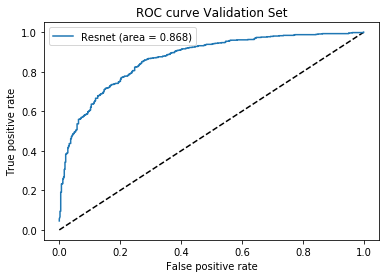

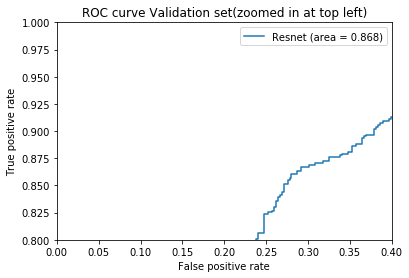

In [16]:
y_pred_probs = model.predict(X_valid)
# Calculate softmax probability
y_pred_probs = y_pred_probs[:,1] / np.sum(y_pred_probs, 1)

# Valid metrics
fpr_valid, tpr_valid, thresholds_test = roc_curve((np.argmax(Y_valid,1)), y_pred_probs)
auc_valid = auc(fpr_valid, tpr_valid)

# Plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_valid, tpr_valid, label='Resnet (area = {:.3f})'.format(auc_valid))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Validation Set')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_valid, tpr_valid, label='Resnet (area = {:.3f})'.format(auc_valid))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Validation set(zoomed in at top left)')
plt.legend(loc='best')
plt.show()

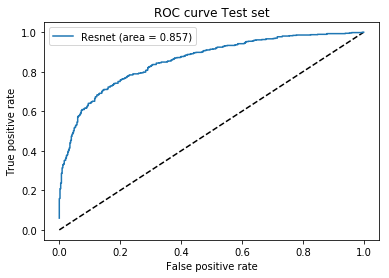

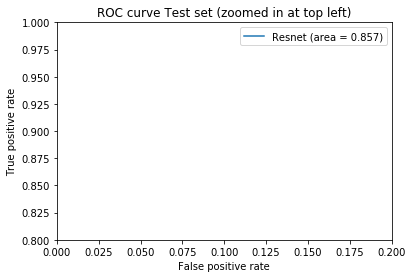

In [17]:
y_pred_probs = model.predict(X_test)
# Calculate softmax probability
y_pred_probs = y_pred_probs[:,1] / np.sum(y_pred_probs, 1)

# Test metrics
fpr_test, tpr_test, thresholds_test = roc_curve((np.argmax(Y_test,1)), y_pred_probs)
auc_test = auc(fpr_test, tpr_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Resnet (area = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test set')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Resnet (area = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Test set (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

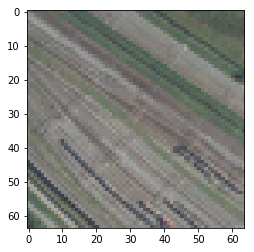

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.00680076 0.98900175]]
Predicted Label: 1




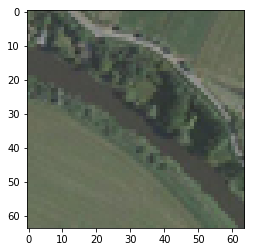

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.00150143 0.9986268 ]]
Predicted Label: 1




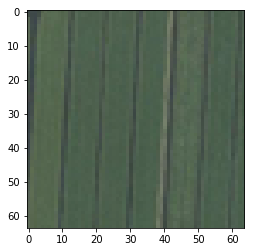

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.10434367 0.7923714 ]]
Predicted Label: 1




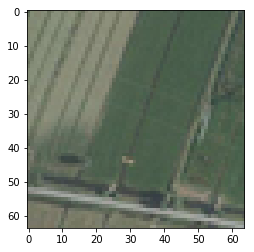

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.0031743 0.995201 ]]
Predicted Label: 1




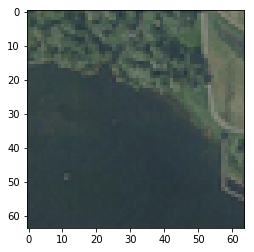

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.00220185 0.9981547 ]]
Predicted Label: 1




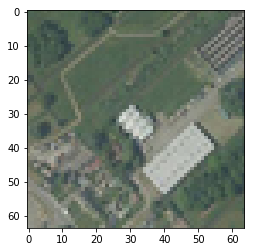

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.1628488 0.8149085]]
Predicted Label: 1




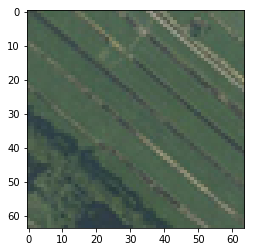

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.0044323  0.99709153]]
Predicted Label: 1




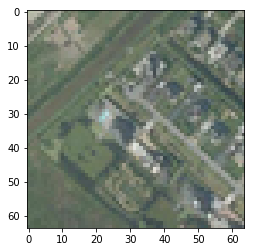

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.00506447 0.9918349 ]]
Predicted Label: 1




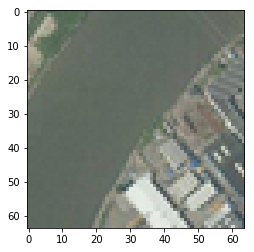

Ground truth labels one hot encode: [0 1]
Ground truth labels: 1
Predicted Probability: [[0.57193214 0.47131386]]
Predicted Label: 0




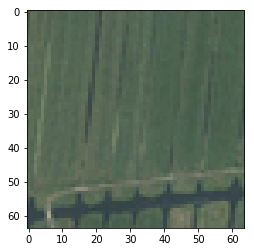

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.05862721 0.9577355 ]]
Predicted Label: 1




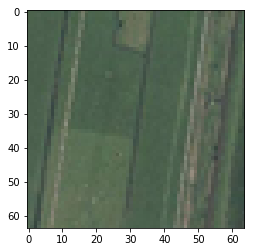

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.46192542 0.65365684]]
Predicted Label: 1




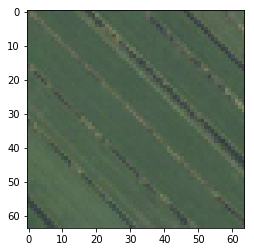

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.02339804 0.95417625]]
Predicted Label: 1




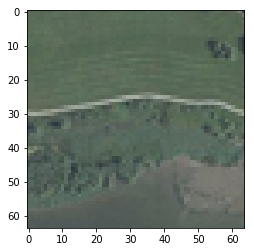

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.18703085 0.77158743]]
Predicted Label: 1




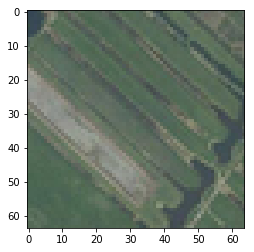

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.05528527 0.9396478 ]]
Predicted Label: 1




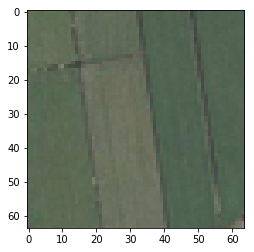

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.01779532 0.9774491 ]]
Predicted Label: 1




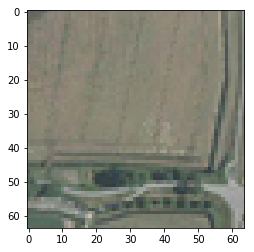

Ground truth labels one hot encode: [0 1]
Ground truth labels: 1
Predicted Probability: [[0.51175237 0.4767585 ]]
Predicted Label: 0




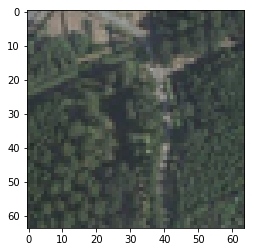

Ground truth labels one hot encode: [1 0]
Ground truth labels: 0
Predicted Probability: [[0.00171298 0.9982083 ]]
Predicted Label: 1




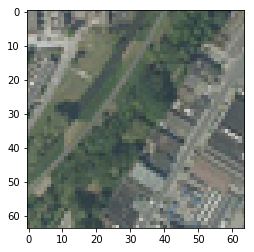

Ground truth labels one hot encode: [0 1]
Ground truth labels: 1
Predicted Probability: [[0.6670977  0.47283643]]
Predicted Label: 0


In [18]:
for i in range(0,40):
    image = X_test[i,:]
    labels = Y_test[i]
    
    img_for_pred = np.ndarray(shape=(1,64,64,3))
    img_for_pred[0,:,:,:] = image
    pred_probs = model.predict(img_for_pred)
    
    #show misclassified examples
    
    if not(np.argmax(pred_probs) == np.argmax(labels)):
        print("\n")
        plt.imshow(image)
        plt.show()
        
        print("Ground truth labels one hot encode: " + str(labels))
        print("Ground truth labels: " + str(np.argmax(labels)))

        print("Predicted Probability: " + str(pred_probs))
        print("Predicted Label: " + str(np.argmax(pred_probs)))